![](../images/logo.png)

# Deposits and FRAs 

In [1]:
import sys
import math
from dateutil.relativedelta import relativedelta
import datetime as dt
from rivapy.tools._validators import print_member_values

from rivapy.marketdata import DiscountCurve
from rivapy.instruments import DepositSpecification, ForwardRateAgreementSpecification
from rivapy.pricing import price

from rivapy.tools.enums import DayCounterType, InterpolationType, ExtrapolationType

from rivapy.pricing.pricing_data import DepositPricingData, ForwardRateAgreementPricingData
from rivapy.pricing.pricing_request import  ForwardRateAgreementPricingRequest
from rivapy.pricing.pricing_request import DepositPricingRequest
from rivapy.pricing.bond_pricing import DeterministicCashflowPricer
from rivapy.pricing.deposit_pricing import DepositPricer
from rivapy.pricing.fra_pricing import ForwardRateAgreementPricer
from rivapy.tools.datetools import _term_to_period, DayCounter, roll_day

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import date2num, DateFormatter
from rivapy.tools.visualization import plot_deposit, plot_fra

%matplotlib inline

C:\Users\GunnarSalentin\OneDrive - RIVACON GmbH\Dokumente\git\RiVaPy\rivapy\__init__.py:11: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')


## Definition of a deposit

A deposit is simply a short-term bond where at the start date the lender pays the nominal amount $N$ to the borrower, and at maturity plus settlement days (i.e. the payment date) the borrower pays back the nominal amount plus the accrued interest. Interest is usually expressed using simple compounding, i.e. the amount paid back at the payment date is $N \cdot (1 + r \cdot \tau)$ where $r$ is the interest rate and $\tau$ is the year fraction between start and end date. \
Deposits can be setup in RIVAPY by providing start and end dates directly or by providing a start date and a term. Other instrument specific dates, e.g. fixing date, end date, or maturity date can be passed explicitly when setting up the instrument or will be derived from default values, e.g. spot_days of 2 days, and business day convention.


In [2]:
# Set up deposit specification
ccy = 'EUR'
ref_date = dt.datetime(2023, 1, 2)
issue_date = ref_date
maturity_date = dt.datetime(2024, 1, 26)
dcc = 'Act360'
rate = .03
notional = 100.
deposit_spec = DepositSpecification(
    obj_id='dummy_id',
    issuer="",
    currency=ccy,
    issue_date=issue_date,
    maturity_date=maturity_date,
    notional=notional,
    rate=rate,
    day_count_convention=dcc,
    roll_convention='NONE', 
    payment_days = 5,
    spot_days = 5
)
print_member_values(deposit_spec)

schedule = deposit_spec.get_schedule()
print("Schedule details:")
dates = schedule._roll_out(
    from_=schedule.start_day,
    to_=schedule.end_day,
    term=schedule.time_period,
    ref_date=ref_date
)
for date in dates:
    print(date.strftime("%Y-%m-%d"))

Number of annual payments is not a whole number but a decimal.


Inspecting instance of DepositSpecification:

accrual_dates: [datetime.datetime(2023, 1, 2, 0, 0), datetime.datetime(2024, 1, 26, 0, 0)]
adjust_accruals: True
adjust_end_date: False
adjust_schedule: True
adjust_start_date: True
backwards: True
business_day_convention: ModifiedFollowing
calendar: {datetime.date(2023, 1, 1): "New Year's Day", datetime.date(2023, 4, 7): 'Good Friday', datetime.date(2023, 4, 10): 'Easter Monday', datetime.date(2023, 5, 1): 'Labour Day', datetime.date(2023, 12, 25): 'Christmas Day', datetime.date(2023, 12, 26): 'Christmas Holiday', datetime.date(2024, 1, 1): "New Year's Day", datetime.date(2024, 3, 29): 'Good Friday', datetime.date(2024, 4, 1): 'Easter Monday', datetime.date(2024, 5, 1): 'Labour Day', datetime.date(2024, 12, 25): 'Christmas Day', datetime.date(2024, 12, 26): 'Christmas Holiday'}
coupon: 0.03
coupon_type: fix
currency: EUR
dates: [datetime.datetime(2023, 1, 2, 0, 0), datetime.datetime(2024, 1, 26, 0, 0)]
day_count_convention: Act360
end_date

End dates of notional structure are not set.
End dates of notional structure are not set.


Cashflows: [(datetime.datetime(2023, 1, 2, 0, 0), -100.0), (datetime.datetime(2024, 1, 31, 0, 0), 3.2416666666666663), (datetime.datetime(2024, 1, 31, 0, 0), 100.0)]

Pricing deposit:


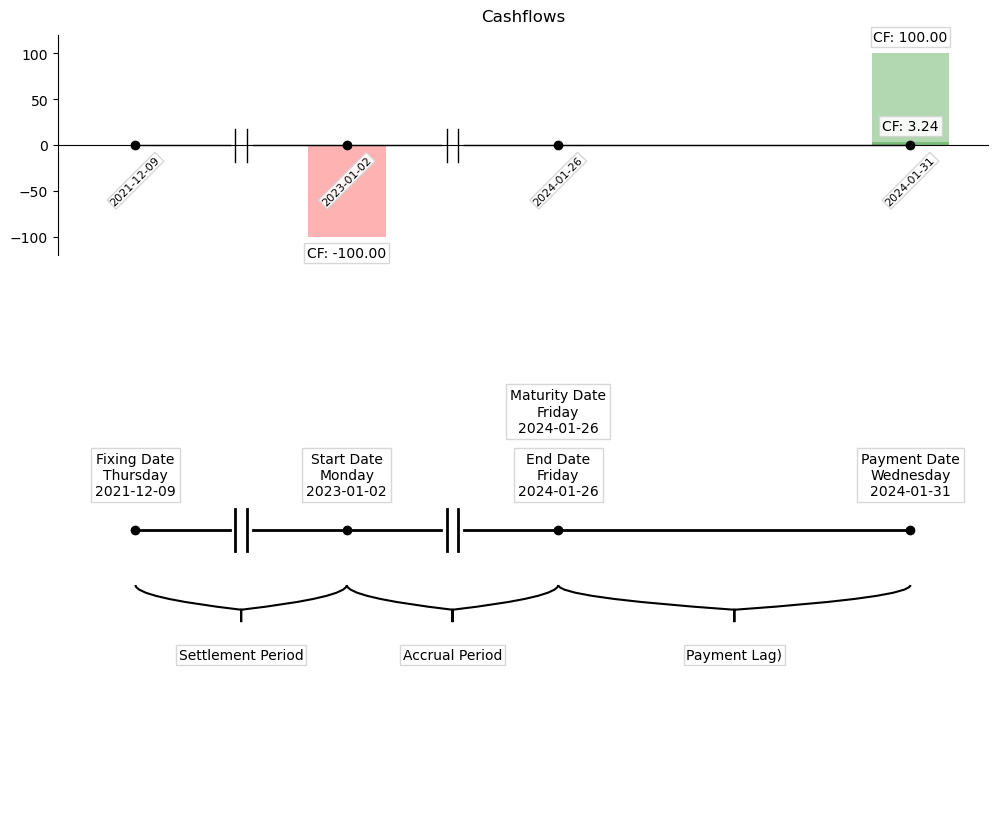

In [3]:
cf = DepositPricer.get_expected_cashflows(deposit_spec)
print(f"Cashflows: {cf}")
print("\nPricing deposit:")
# add timeline plot
fig = plot_deposit(deposit_spec, ref_date)
plt.show()

In [4]:
term = "3M"
deposit_spec_3M = DepositSpecification(
    obj_id='dummy_id',
    issuer="",
    currency=ccy,
    issue_date=ref_date,
    term=term,
    notional=notional,
    rate=rate,
    day_count_convention=dcc,
    roll_convention='NONE',  # explicitly pass as string
    payment_days=0
)
print_member_values(deposit_spec_3M)

Inspecting instance of DepositSpecification:

accrual_dates: [datetime.datetime(2023, 1, 2, 0, 0), datetime.datetime(2023, 4, 3, 0, 0)]
adjust_accruals: True
adjust_end_date: False
adjust_schedule: True
adjust_start_date: True
backwards: True
business_day_convention: ModifiedFollowing
calendar: {datetime.date(2023, 1, 1): "New Year's Day", datetime.date(2023, 4, 7): 'Good Friday', datetime.date(2023, 4, 10): 'Easter Monday', datetime.date(2023, 5, 1): 'Labour Day', datetime.date(2023, 12, 25): 'Christmas Day', datetime.date(2023, 12, 26): 'Christmas Holiday', datetime.date(2024, 1, 1): "New Year's Day", datetime.date(2024, 3, 29): 'Good Friday', datetime.date(2024, 4, 1): 'Easter Monday', datetime.date(2024, 5, 1): 'Labour Day', datetime.date(2024, 12, 25): 'Christmas Day', datetime.date(2024, 12, 26): 'Christmas Holiday', datetime.date(2021, 1, 1): "New Year's Day", datetime.date(2021, 4, 2): 'Good Friday', datetime.date(2021, 4, 5): 'Easter Monday', datetime.date(2021, 5, 1): 'Labour

In [5]:
# Set up (flat) rate curve
object_id = "TEST_CURVE"
flat_rate = 0.025

days_to_maturity = [1, 180, 365, 720, 3 * 365, 4 * 365, 10 * 365]
dates = [ref_date + dt.timedelta(days=d) for d in days_to_maturity]

df = [math.exp(-d / 365.0 * flat_rate) for d in days_to_maturity]
dc = DiscountCurve(id=object_id, refdate=ref_date, dates=dates, df=df, interpolation = InterpolationType.LINEAR, extrapolation=ExtrapolationType.LINEAR)

In [6]:
# price deposit
print (f"Expected Cashflows: {DeterministicCashflowPricer.get_expected_cashflows(deposit_spec,ref_date)}")
print(f"Price Deposit: {DepositPricer.get_price(ref_date, deposit_spec, dc)}")

# Determine fair rate
fair_rate = DepositPricer.get_implied_simply_compounded_rate(ref_date, deposit_spec, dc)
print(f"fair rate: {fair_rate}")

# new deposit with fair rate
fair_deposit_spec = DepositSpecification(obj_id ='dummy_id', issuer='dummy_issuer', securitization_level ='NONE', 
                                    currency=ccy, issue_date=ref_date, maturity_date=deposit_spec.end_date, notional=deposit_spec.notional, rate=fair_rate, 
                                    day_count_convention=deposit_spec.day_count_convention, payment_days=deposit_spec.payment_days, spot_days=deposit_spec.spot_days)
#print_member_values(fair_deposit_spec)
print(f"fair deposit coupon: {fair_deposit_spec.coupon}")
#print(DepositPricer.get_price(ref_date, fair_deposit_spec, dc)) 



End dates of notional structure are not set.
End dates of notional structure are not set.


Expected Cashflows: [(datetime.datetime(2023, 1, 2, 0, 0), -100.0), (datetime.datetime(2024, 1, 31, 0, 0), 3.2416666666666663), (datetime.datetime(2024, 1, 31, 0, 0), 100.0)]
Price Deposit: 100.4950269333136
fair rate: 0.024971370182974097
fair deposit coupon: 0.024971370182974097


In [7]:
# Check fair rate
# discount factor from curve
print(f"fair_deposit_spec.start_date: {fair_deposit_spec.start_date}, fair_deposit_spec.end_date: {fair_deposit_spec.end_date}")
df_curve = dc.value_fwd(ref_date, fair_deposit_spec.start_date, fair_deposit_spec.end_date)
# discount factor implied by fair rate (simple compounding, Act/360)
dcc = DayCounter(fair_deposit_spec.day_count_convention)
#print(f"day count convention: {fair_deposit_spec.day_count_convention}")
delta_t = dcc.yf(fair_deposit_spec.start_date, fair_deposit_spec.end_date)
df_implied = 1. / (1. + delta_t * fair_rate)
#print(f"Discount factor from curve: {df_curve}, Delta t: {delta_t}, Implied DF: {df_implied}, dcc: {dcc}")
print(df_curve)
print(df_implied)


fair_deposit_spec.start_date: 2023-01-02 00:00:00, fair_deposit_spec.end_date: 2024-01-26 00:00:00
0.9737259973907282
0.9737259973907281


The deposit's cashflows including relevant dates are shown below:

Found start date 2022-10-02 00:00:00 such that calc_end_day(start_date, ...) == end_day, but start date is not a business day in the given calendar.
End dates of notional structure are not set.


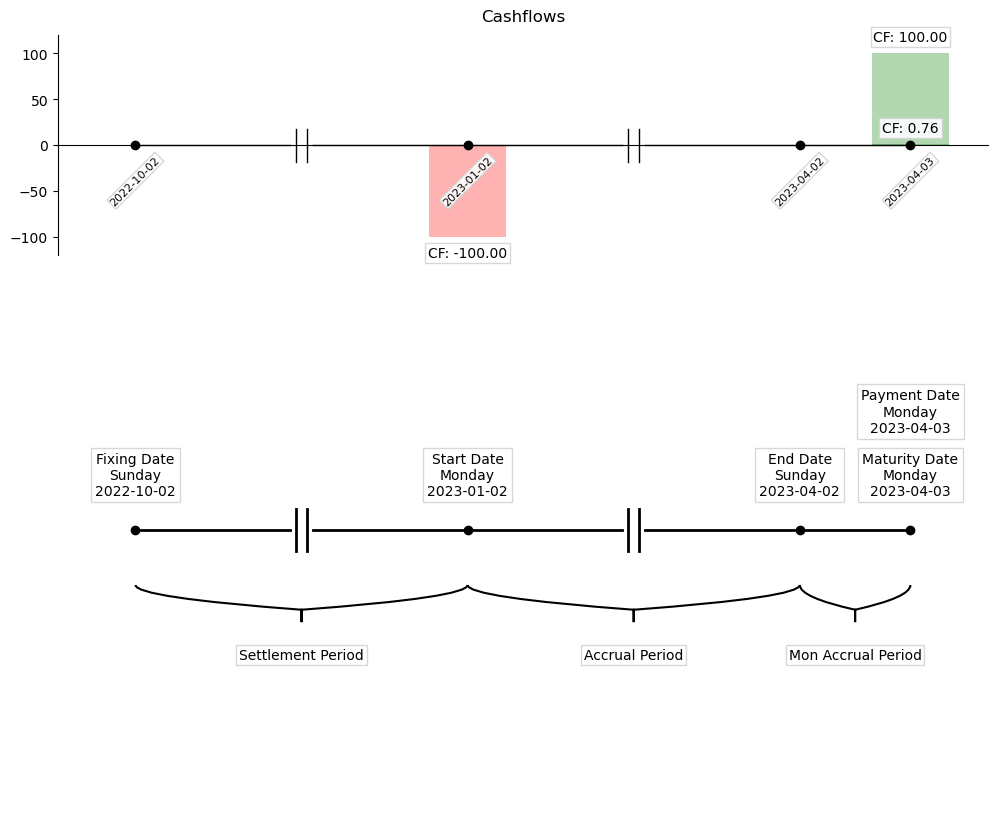

In [8]:
fig = plot_deposit(deposit_spec_3M, ref_date)
plt.show()

## Definition of a forward rate agreement (FRA)

A forward rate agreement is in principle a forward-starting deposit for a time period $[T_1, T_2]$ in the future (which is concluded at a start date $T_0$). However, rather than actually entering into a deposit at time $T_1$, an FRA is "cash-settled" at $T_1$ by exchanging the present value of the agreement (using the fixing of the underlying index to discount the cash flows from $T_2$ to $T_1$):
$$PV(T_1) = N \tau \frac {r - K} {1 + r\cdot \tau}$$
where
- $N$ is the nominal amount
- $\tau$ is the year fraction between $T_1$ and $T_2$
- $r$ is the index fixing at $T_1$ for the period $[T_1, T_2]$
- $K$ is the forward rate agreed upon at $T_0$

In [9]:
# Set up FRA
ccy = 'EUR'
fra_rate = .04
ref_date = dt.datetime(2023, 1,28)
start_date = dt.datetime(2023, 7, 28)
end_date = dt.datetime(2023, 10, 28)

mat_date = ref_date + dt.timedelta(days=365)

fra = ForwardRateAgreementSpecification( 
        obj_id= 'dummy_id',
        trade_date=ref_date,
        #maturity_date=mat_date,
        notional= 1000.0,
        rate= fra_rate,
        start_date=start_date,
        end_date=end_date,
        udlID= "dummy_underlying_index",
        rate_start_date=start_date,
        rate_end_date=end_date,
        day_count_convention= 'Act360',
        #business_day_convention: _Union[RollConvention, str] = RollConvention.FOLLOWING,
        rate_day_count_convention= 'Act360',
        #rate_business_day_convention: _Union[RollConvention, str] = RollConvention.FOLLOWING,
        #calendar: _Union[_HolidayBase, str] = None,
        currency=ccy,
        # ex_settle: int =0,
        # trade_settle: int= 0,
        spot_days = 1,
        payment_days = 1,
        #start_period: int = None,
        #end_period: int = None,
        issuer= "dummy_issuer",
        securitization_level= "NONE",
        #rating: _Union[Rating, str] = Rating.NONE, ''
)


In [10]:
# Set up curves for pricing
# Discount curve
object_id = "TEST_DC"
dsc_rate = 0.01
days_to_maturity = [1, 180, 365, 720, 3 * 365, 4 * 365, 10 * 365]
dates = [ref_date + dt.timedelta(days=d) for d in days_to_maturity]
df = [math.exp(-d / 365.0 * dsc_rate) for d in days_to_maturity]
dc = DiscountCurve(id=object_id, refdate=ref_date, dates=dates, df=df, interpolation= InterpolationType.LINEAR)

# Fixing curve
object_id = "TEST_fwd"
fwd_rate = 0.05
fwd_df = [math.exp(-d / 365.0 * fwd_rate) for d in days_to_maturity]
fwd_dc = DiscountCurve(id=object_id, refdate=ref_date, dates=dates, df=fwd_df,interpolation= InterpolationType.LINEAR)

Day count fraction (yf): 0.25205479452054796, Forward rate: 0.05000074869501186
dt: 0.25555555555555554, Specification_Rate: 0.04, Amount: 2.555746888725252
Cashflow: 2.5235016624312805


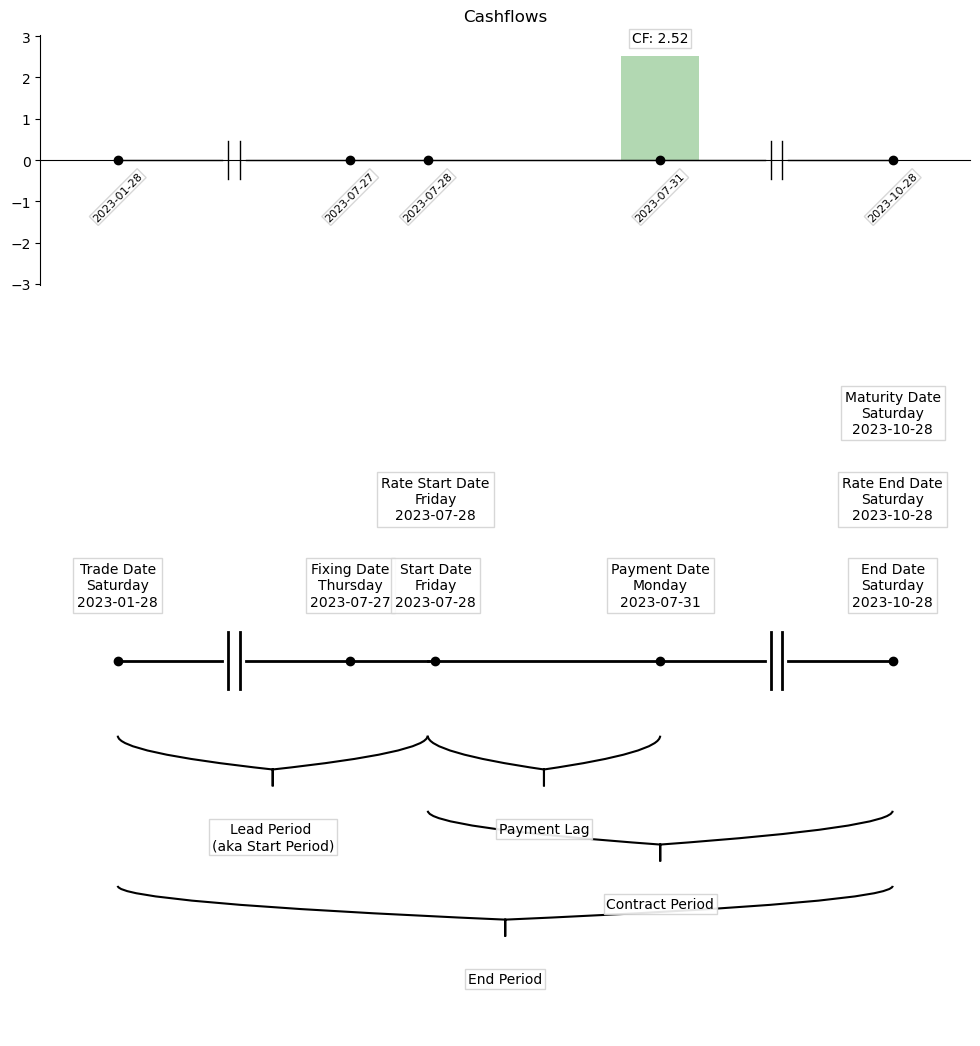

2023-10-28 00:00:00


In [11]:
fig = plot_fra(fra, ref_date, fwd_dc)
plt.show()
print(fra._maturity_date)

In [12]:
# Price FRA 
fra_pricing_data = ForwardRateAgreementPricingData(fra= fra, val_date= ref_date, pricing_request = ForwardRateAgreementPricingRequest(), 
                                                   pricer = "ForwardRateAgreementPricer", discount_curve = dc, forward_curve = fwd_dc,
                                                   parameters = {})
fra_pricer = ForwardRateAgreementPricer(ref_date, fra, dc, fwd_dc)
fra_price =  fra_pricing_data.price()
# print(f'Price: {fra_price}')
# expCF = fra_pricer.expected_cashflows()
# print(f'Expected Cashflows: {expCF}')

Day count fraction (yf): 0.25205479452054796, Forward rate: 0.05000074869501186
dt: 0.25555555555555554, Specification_Rate: 0.04, Amount: 2.555746888725252
Cashflow: 2.5235016624312805


In [13]:
# Calculate fair FRA rate (from froward curve)

pricer =  ForwardRateAgreementPricer(val_date= ref_date, fra_spec = fra, discount_curve=dc, forward_curve=fwd_dc )
fair_rate = ForwardRateAgreementPricer.compute_fair_rate(ref_date, fra, fwd_dc)
print(fair_rate)


0.05000074869501186


In [14]:
# Check that "fair" FRA has indeed price 0, use same instrument as before but apply the fair rate from the previous step
fair_fra = ForwardRateAgreementSpecification( 
        obj_id= 'fair_dummy_id',
        trade_date=ref_date,
        maturity_date=mat_date,
        notional= 1000.0,
        rate= fair_rate,
        start_date=start_date,
        end_date=end_date,
        udlID= "dummy_underlying_index",
        rate_start_date=start_date,
        rate_end_date=end_date,
        day_count_convention= 'Act360',
        #business_day_convention: _Union[RollConvention, str] = RollConvention.FOLLOWING,
        rate_day_count_convention= 'Act360',
        #rate_business_day_convention: _Union[RollConvention, str] = RollConvention.FOLLOWING,
        #calendar: _Union[_HolidayBase, str] = None,
        currency=ccy,
        # ex_settle: int =0,
        # trade_settle: int= 0,
        #spot_days: int = None,
        #start_period: int = None,
        #end_period: int = None,
        issuer= "dummy_issuer",
        securitization_level= "NONE",
        #rating: _Union[Rating, str] = Rating.NONE, ''
)


fair_fra_pricing_data = ForwardRateAgreementPricingData(fra= fair_fra, val_date= ref_date, pricing_request = ForwardRateAgreementPricingRequest(), 
                                                   pricer = "ForwardRateAgreementPricer", discount_curve = dc, forward_curve = fwd_dc,
                                                   parameters = {})

fair_fra_price =  fair_fra_pricing_data.price()
print(f'Price: {fair_fra_price}')

Day count fraction (yf): 0.25205479452054796, Forward rate: 0.05000074869501186
dt: 0.25555555555555554, Specification_Rate: 0.05000074869501186, Amount: 0.0
Cashflow: 0.0
Price: 0.0
